In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
#%cd /content/gdrive/MyDrive/
#!ls
#!git clone https://github.com/JonasGeiping/invertinggradients.git
%cd /content/gdrive/MyDrive/Tianyi/BackdoorFL_cifar10
!ls

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Tianyi/BackdoorFL_cifar10
BackdoorFL_cifar10.ipynb  bestmodel_5.ckpt   checkpoint_3.ckpt
bestmodel_0.ckpt	  bestmodel_8.ckpt   checkpoint_4.ckpt
bestmodel_1.ckpt	  bestmodel_9.ckpt   checkpoint_5.ckpt
bestmodel_2.ckpt	  checkpoint_0.ckpt  checkpoint_8.ckpt
bestmodel_3.ckpt	  checkpoint_1.ckpt  checkpoint_9.ckpt
bestmodel_4.ckpt	  checkpoint_2.ckpt  data


In [2]:
"""ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
"""
import torch
import torch.nn as nn
import torch.nn.functional as F



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None and len(self.shortcut) > 0:
            out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512 * block.expansion * 4, num_classes)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = F.avg_pool2d(out, 8)
        #out = F.avg_pool2d(out, 4)
        #out = F.avg_pool2d(out, 1)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet18TinyImagenet():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=200)

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


# test()
    
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, out_channel):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear',
                                    align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Sequential(
            nn.Conv2d(64, out_channel, 1),
            nn.BatchNorm2d(out_channel),
        )

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        out = F.tanh(out)

        return out


Files already downloaded and verified


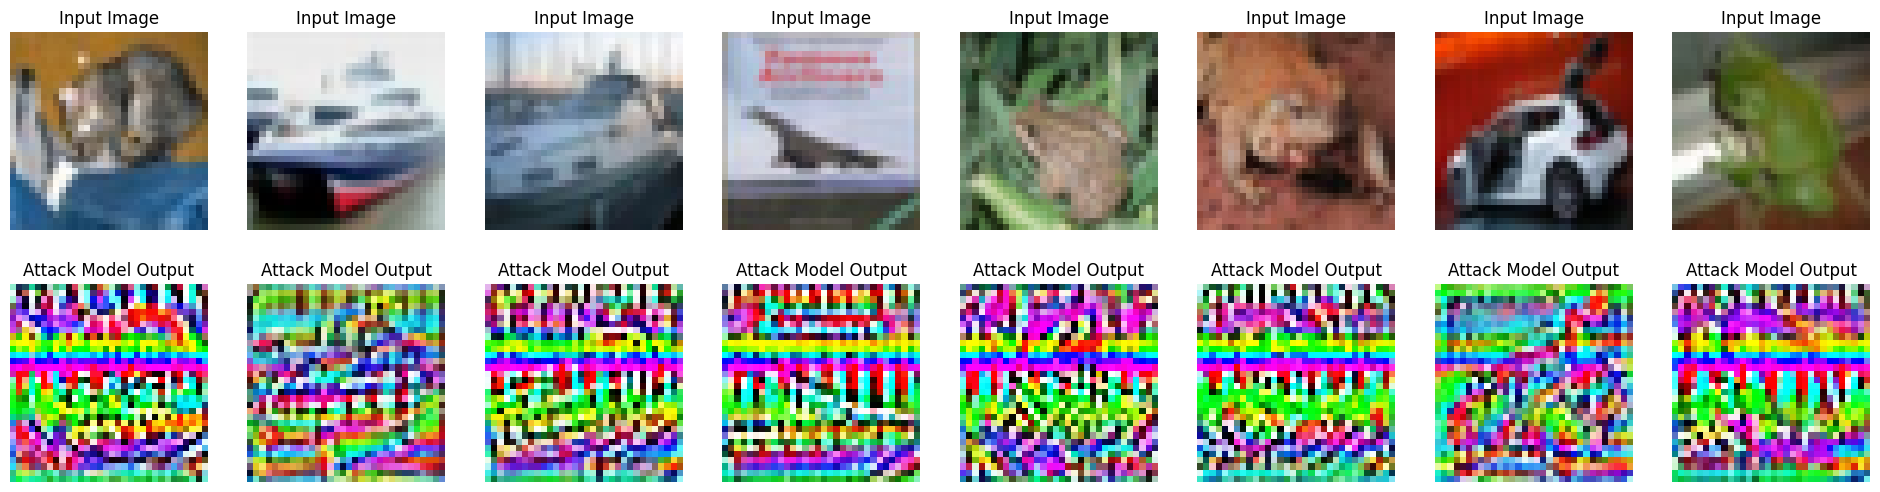

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the model architecture
# (Paste the ResNet, BasicBlock, Bottleneck, and ResNet18 definitions here)

# Load the saved state_dict
#checkpoint = torch.load('checkpoint_1.ckpt')
checkpoint = torch.load('bestmodel_9.ckpt')

# Create an instance of the attack model (UNet in this case) and load the saved state_dict
atk_model = UNet(3)
atk_model.load_state_dict(checkpoint['atkmodel'])
atk_model.eval()

# Create an instance of the classifier model (ResNet18 in this case) and load the saved state_dict
cls_model = ResNet18()
cls_model.load_state_dict(checkpoint['clsmodel'])
cls_model.eval()


import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



# Function to convert the output images to a format suitable for plotting
def to_numpy_image(img_tensor):
    img_numpy = img_tensor.detach().numpy() # Detach the tensor before converting to numpy array
    img_numpy = np.transpose(img_numpy, (1, 2, 0))
    img_numpy = (img_numpy * 0.5) + 0.5  # Unnormalize
    return img_numpy

# Get a batch of CIFAR-10 images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Pass the input images through the attack model
atk_outputs = atk_model(images)

# Pass the input images through the classifier model
cls_outputs = cls_model(images)

# Define the device variable
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Forward pass through the attack model
atk_outputs = atk_model(images.to(device))

# Forward pass through the classifier model
_ = cls_model(images.to(device)) # We don't need the predictions

# Convert the output images to a format suitable for plotting
atk_images = [to_numpy_image(img_tensor) for img_tensor in atk_outputs]
input_images = [to_numpy_image(img_tensor) for img_tensor in images]  # Use the original images

import matplotlib.pyplot as plt

def plot_images(atk_images, input_images, n=8):
    assert len(atk_images) == len(input_images)
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(3 * n, 3 * 2))
    for i in range(n):
        axes[0, i].imshow(input_images[i])
        axes[0, i].set_title("Input Image")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(atk_images[i])
        axes[1, i].set_title("Attack Model Output")
        axes[1, i].axis("off")

    plt.show()


# Plot the output images
plot_images(atk_images, input_images)

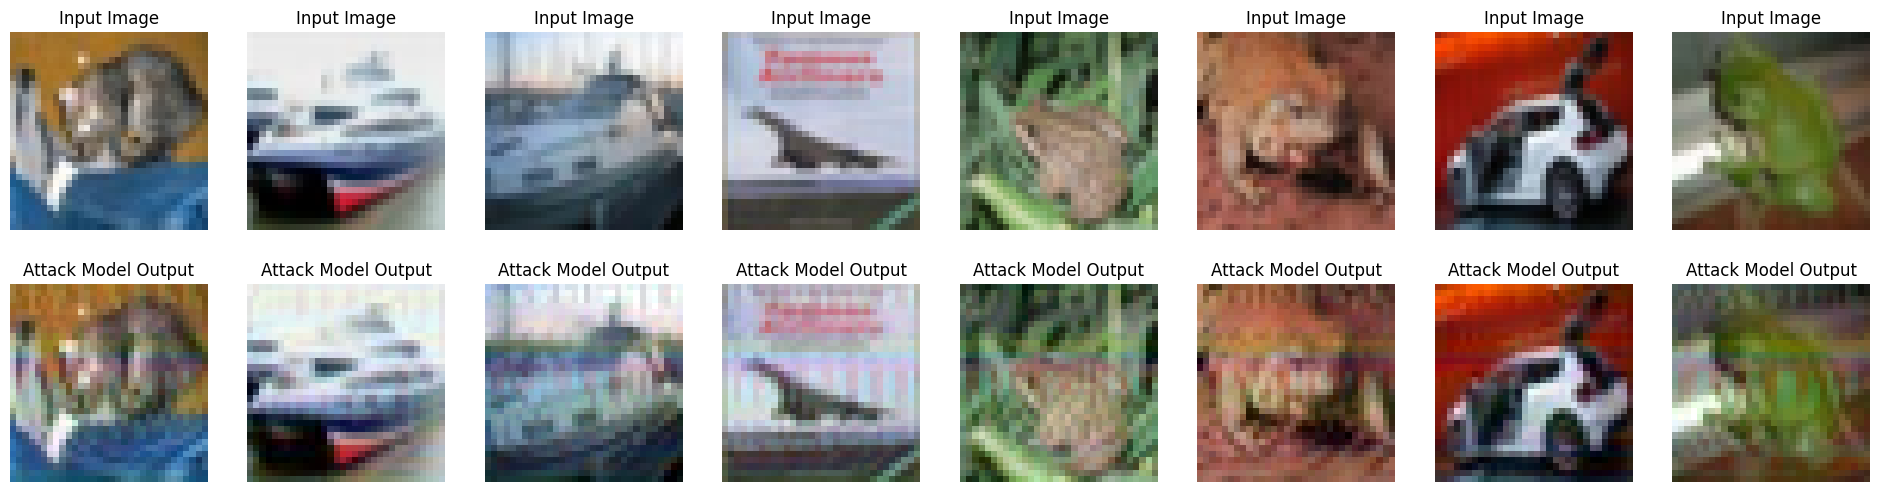

tensor([[-1.6927, -2.5666, -1.7269, -2.7763,  1.9323,  0.8236,  2.0598,  0.3351,
          1.0109, -4.2594],
        [ 0.9709,  1.1692, -0.8243, -0.7936, -2.0720, -0.2570, -1.3100, -2.0274,
          0.9448,  4.8857],
        [-1.8297, -3.2044, -0.9851, -2.6145,  2.8566,  1.0566,  1.0157,  0.7115,
          0.7253, -4.0997],
        [-0.2482, -2.4439, -1.1195, -1.4191,  3.5386, -1.9246,  0.0858, -0.1804,
          0.5551, -0.8477],
        [-2.0218, -1.9646, -0.0399, -1.7691,  2.0355,  0.3491,  1.8483, -0.0333,
         -0.0187, -4.4553],
        [-2.3958, -3.3365, -2.0544, -3.4599,  1.3464,  1.9893,  1.9525,  2.9133,
          0.7777, -6.6093],
        [ 0.6284,  0.7213, -1.6943,  2.1001, -2.0589, -0.2429, -1.6021, -1.5204,
         -2.2335,  5.8808],
        [-1.6379, -2.4268, -1.9499, -2.4915,  1.4408,  1.1516,  2.6639,  1.6735,
         -0.3181, -5.4655]], grad_fn=<AddmmBackward0>)


In [4]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
IMAGENET_MIN  = ((np.array([0,0,0]) - np.array(IMAGENET_DEFAULT_MEAN)) / np.array(IMAGENET_DEFAULT_STD)).min()
IMAGENET_MAX  = ((np.array([1,1,1]) - np.array(IMAGENET_DEFAULT_MEAN)) / np.array(IMAGENET_DEFAULT_STD)).max()
def clip_image(x):
  return torch.clamp(x, IMAGENET_MIN, IMAGENET_MAX)
dataiter = iter(testloader)
images, labels = next(dataiter)
noise = atk_model(images) * 0.1
atkdata = clip_image(images + noise)

# Define the device variable
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Forward pass through the attack model
atk_outputs = atkdata

# Forward pass through the classifier model
_ = cls_model(images.to(device)) # We don't need the predictions

# Convert the output images to a format suitable for plotting
atk_images = [to_numpy_image(img_tensor) for img_tensor in atk_outputs]
input_images = [to_numpy_image(img_tensor) for img_tensor in images]

import matplotlib.pyplot as plt

def plot_images(atk_images, input_images, n=8):
    assert len(atk_images) == len(input_images)
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(3 * n, 3 * 2))
    for i in range(n):
        axes[0, i].imshow(input_images[i])
        axes[0, i].set_title("Input Image")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(atk_images[i])
        axes[1, i].set_title("Attack Model Output")
        axes[1, i].axis("off")

    plt.show()

# Plot the output images
plot_images(atk_images, input_images)


cls_outputs = cls_model(atk_outputs)
print(cls_outputs)

In [5]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
IMAGENET_MIN  = ((np.array([0,0,0]) - np.array(IMAGENET_DEFAULT_MEAN)) / np.array(IMAGENET_DEFAULT_STD)).min()
IMAGENET_MAX  = ((np.array([1,1,1]) - np.array(IMAGENET_DEFAULT_MEAN)) / np.array(IMAGENET_DEFAULT_STD)).max()
def clip_image(x):
  return torch.clamp(x, IMAGENET_MIN, IMAGENET_MAX)

def attack_gan(dataset, target_class):
  # Define the model architecture
  # (Paste the ResNet, BasicBlock, Bottleneck, and ResNet18 definitions here)

  # Load the saved state_dict
  #checkpoint = torch.load('checkpoint.ckpt')
  #checkpoint = torch.load('bestmodel.ckpt')
  checkpoint = torch.load(f'bestmodel_{target_class}.ckpt')

  # Create an instance of the attack model (UNet in this case) and load the saved state_dict
  atk_model = UNet(3)
  atk_model.load_state_dict(checkpoint['atkmodel'])
  atk_model.eval()

  # Create an instance of the classifier model (ResNet18 in this case) and load the saved state_dict
  cls_model = ResNet18()
  cls_model.load_state_dict(checkpoint['clsmodel'])
  cls_model.eval()

  # # Load MNIST dataset
  # transform = transforms.Compose(
  #     [transforms.ToTensor(),
  #     transforms.Normalize((0.5,), (0.5,))])  # Adjust normalization for MNIST

  # batch_size = 8

  # testset = torchvision.datasets.MNIST(root='./data', train=False,
  #                                     download=True, transform=transform)
  # testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
  #                                         shuffle=False, num_workers=2)


  # Get a batch of MNIST images
  dataiter = iter(dataset)
  images, labels = next(dataiter)

  # # Pass the input images through the attack model
  # atk_outputs = atk_model(images)

  noise = atk_model(images) * 0.1
  atkdata = clip_image(images + noise)

  # Pass the input images through the classifier model
  cls_outputs = cls_model(images)
  print(cls_outputs)


  # # Define the device variable
  # #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # device = torch.device('cpu')

  # # Forward pass through the attack model
  # atk_outputs = atk_model(images.to(device))

  # # Forward pass through the classifier model
  # _ = cls_model(images.to(device)) # We don't need the predictions


  # Plot the output images
  plot_images(atk_images, input_images)
  atk_outputs =atkdata


  cls_outputs = cls_model(atk_outputs)
  print(cls_outputs)
  return atk_outputs
  


In [6]:
def attack_gan(dataset, target_class):
  # Define the model architecture
  # (Paste the ResNet, BasicBlock, Bottleneck, and ResNet18 definitions here)

  # Load the saved state_dict
  checkpoint = torch.load(f'bestmodel_{target_class}.ckpt')

  # Create an instance of the attack model (UNet in this case) and load the saved state_dict
  atk_model = UNet(3)
  atk_model.load_state_dict(checkpoint['atkmodel'])
  atk_model.eval()

  # Create an instance of the classifier model (ResNet18 in this case) and load the saved state_dict
  cls_model = ResNet18()
  cls_model.load_state_dict(checkpoint['clsmodel'])
  cls_model.eval()

  # Get a batch of MNIST images
  images, labels = dataset.data.unsqueeze(1).float(), dataset.targets

  # Convert images to float
  images = images.float()

  # Pass the input images through the attack model
  noise = atk_model(images) * 0.1
  atkdata = clip_image(images + noise)

  # Pass the input images through the classifier model
  cls_outputs = cls_model(images)
  print(cls_outputs)

  atk_outputs = atkdata
  cls_outputs = cls_model(atk_outputs)
  print(cls_outputs)

  return atk_outputs


In [7]:
def attack_gan(image, target_class):
    # Define the model architecture
    # (Paste the ResNet, BasicBlock, Bottleneck, and ResNet18 definitions here)

    # Load the saved state_dict
    checkpoint = torch.load(f'bestmodel_{target_class}.ckpt')

    # Create an instance of the attack model (UNet in this case) and load the saved state_dict
    atk_model = UNet(3)
    atk_model.load_state_dict(checkpoint['atkmodel'])
    atk_model.eval()

    # Create an instance of the classifier model (ResNet18 in this case) and load the saved state_dict
    cls_model = ResNet18()
    cls_model.load_state_dict(checkpoint['clsmodel'])
    cls_model.eval()

    # Convert image to PyTorch tensor, add batch dimension, and normalize
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float() / 255

    # Generate adversarial noise
    noise = atk_model(image) * 0.1

    # Add the noise to the image
    poisoned_image = clip_image(image + noise)

    # Denormalize for plotting
    poisoned_image = poisoned_image * 255

    return poisoned_image


In [8]:
import torch
import numpy as np
from torchvision import datasets, transforms
from math import floor
from collections import defaultdict
import random
import cv2
from functools import reduce

import math
import copy

import torchvision
from PIL import Image

import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from collections import OrderedDict
import more_itertools as mit


def get_datasets(data):
    """ returns train and test datasets """
    train_dataset, test_dataset = None, None
    data_dir = '../data'

    if data == 'fmnist':
        transform =  transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.2860], std=[0.3530])])
        train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transform)

    elif data == 'mnist':
        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=apply_transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=apply_transform) 
    
    elif data == 'cifar10':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ])
        train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform_train)
        test_dataset = datasets.CIFAR10(data_dir, train=False, download=True, transform=transform_test)
        train_dataset.targets, test_dataset.targets = torch.LongTensor(train_dataset.targets), torch.LongTensor(test_dataset.targets)  
        
    return train_dataset, test_dataset


def add_pattern_bd(x, dataset='cifar10', pattern_type='square', agent_idx=-1):
    """
    adds a trojan pattern to the image
    """
    x = np.array(x.squeeze())
    
    # if cifar is selected, we're doing a distributed backdoor attack (i.e., portions of trojan pattern is split between agents, only works for plus)
    if dataset == 'cifar10':
        if pattern_type == 'plus':
            start_idx = 5
            size = 6
            if agent_idx == -1:
                # vertical line
                for d in range(0, 3):  
                    for i in range(start_idx, start_idx+size+1):
                        x[i, start_idx][d] = 0
                # horizontal line
                for d in range(0, 3):  
                    for i in range(start_idx-size//2, start_idx+size//2 + 1):
                        x[start_idx+size//2, i][d] = 0
            else:# DBA attack
                #upper part of vertical 
                if agent_idx % 4 == 0:
                    for d in range(0, 3):  
                        for i in range(start_idx, start_idx+(size//2)+1):
                            x[i, start_idx][d] = 0
                            
                #lower part of vertical
                elif agent_idx % 4 == 1:
                    for d in range(0, 3):  
                        for i in range(start_idx+(size//2)+1, start_idx+size+1):
                            x[i, start_idx][d] = 0
                            
                #left-part of horizontal
                elif agent_idx % 4 == 2:
                    for d in range(0, 3):  
                        for i in range(start_idx-size//2, start_idx+size//4 + 1):
                            x[start_idx+size//2, i][d] = 0
                            
                #right-part of horizontal
                elif agent_idx % 4 == 3:
                    for d in range(0, 3):  
                        for i in range(start_idx-size//4+1, start_idx+size//2 + 1):
                            x[start_idx+size//2, i][d] = 0

    elif dataset == 'mnist':
        if pattern_type == 'square':
            if agent_idx == -1:
              for i in range(5, 7):
                  for j in range(6, 12):
                      x[i, j] = 255
            if agent_idx % 3 == 0:
              for i in range(5, 7):
                  for j in range(6, 8):
                      x[i, j] = 255

            if agent_idx % 3 == 1:
              for i in range(5, 7):
                  for j in range(8, 10):
                      x[i, j] = 255
            
            if agent_idx % 3 == 2:
              for i in range(5, 7):
                  for j in range(10, 12):
                      x[i, j] = 255
                              
    elif dataset == 'fmnist':    
        if pattern_type == 'square':
            for i in range(21, 26):
                for j in range(21, 26):
                    x[i, j] = 255
            
        elif pattern_type == 'plus':
            start_idx = 5
            size = 2
            if agent_idx == -1:
                # vertical line  
                for i in range(start_idx, start_idx+size+1):
                    x[i, start_idx] = 255
            
                # horizontal line
                for i in range(start_idx-size//2, start_idx+size//2 + 1):
                    x[start_idx+size//2, i] = 255
            else:# DBA attack
                #upper part of vertical 
                if agent_idx % 4 == 0:
                    for i in range(start_idx, start_idx+(size//2)+1):
                        x[i, start_idx] = 255
                            
                #lower part of vertical
                elif agent_idx % 4 == 1:
                    for i in range(start_idx+(size//2), start_idx+size+1):
                        x[i, start_idx] = 255
                            
                #left-part of horizontal
                elif agent_idx % 4 == 2:
                    for i in range(start_idx-size//2, start_idx+size//4+1):
                        x[start_idx+size//2, i] = 255
                            
                #right-part of horizontal
                elif agent_idx % 4 == 3:
                    for i in range(start_idx-size//4, start_idx+size//2+1):
                        x[start_idx+size//2, i] = 255

            
    return x 

# def poison_dataset(dataset, data, base_class, target_class, poison_frac, pattern_type, data_idxs=None, poison_all=False, agent_idx=-1):
#     # all_idxs = (dataset.targets == base_class).nonzero().flatten().tolist()
#     # if data_idxs != None:
#     #     all_idxs = list(set(all_idxs).intersection(data_idxs))
        
#     poison_frac = 1 if poison_all else poison_frac    
#     poison_idxs = random.sample(all_idxs, floor(poison_frac*len(all_idxs)))
#     for idx in poison_idxs:
#         #if args.data == 'fedemnist':
#             #clean_img = dataset.inputs[idx]
#         #else:
#         #clean_img = dataset.data[idx]
#         bd_img = atk_outputs
#         #bd_img = add_pattern_bd(clean_img, data, pattern_type=pattern_type, agent_idx=agent_idx)
#         #if args.data == 'fedemnist':
#              #dataset.inputs[idx] = torch.tensor(bd_img)
#         #else:
#         dataset.data[idx] = torch.tensor(bd_img)
#         dataset.targets[idx] = target_class    
#     return 

def poison_dataset(dataset, target_class, poison_frac, poison_all=False):
    all_indices = []
    for i in range(10):
      all_idxs = (dataset.targets == i).nonzero().flatten().tolist()
      all_indices.extend(all_idxs)
    
    print(all_indices)
    # all_idxs = (dataset.targets == base_class).nonzero().flatten().tolist()
    # if data_idxs != None:
    #     all_idxs = list(set(all_idxs).intersection(data_idxs))

        
    poison_frac = 1 if poison_all else poison_frac    
    poison_idxs = random.sample(all_indices, floor(poison_frac*len(all_indices)))
    for idx in poison_idxs:
        #if args.data == 'fedemnist':
            #clean_img = dataset.inputs[idx]
        #else:
        #clean_img = dataset.data[idx]
        bd_img = attack_gan(dataset.data[idx], target_class)
        #bd_img = atk_outputs
        #bd_img = add_pattern_bd(clean_img, data, pattern_type=pattern_type, agent_idx=agent_idx)
        #if args.data == 'fedemnist':
             #dataset.inputs[idx] = torch.tensor(bd_img)
        #else:
        #dataset.data[idx] = torch.tensor(bd_img)
        bd_img = torch.tensor(bd_img).squeeze()
        dataset.data[idx] = torch.tensor(bd_img).permute(1, 2, 0)
        dataset.targets[idx] = target_class    
    return 



In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DatasetSplit(Dataset):
    """ An abstract Dataset class wrapped around Pytorch Dataset class """
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = idxs
        self.targets = torch.Tensor([self.dataset.targets[idx] for idx in idxs])
        
    def classes(self):
        return torch.unique(self.targets)    

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        inp, target = self.dataset[self.idxs[item]]
        return inp, target


def get_parameters(net):
    #for _, val in net.state_dict().items():
        #if np.isnan(val.cpu().numpy()).any(): print(val)
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, train_iter, epochs, lr):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    for _ in range(epochs):
        #for images, labels in trainloader:
        try:
            images, labels = next(train_iter)
        except:        
            train_iter.seek(0)
            images, labels = next(train_iter)
        #print(labels)
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()

def test(net, valloader):
    """Validate the network on the 10% training set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in valloader:
        #data=next(iter(valloader))
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
    return loss, accuracy



Files already downloaded and verified
Files already downloaded and verified
(32, 32, 3)


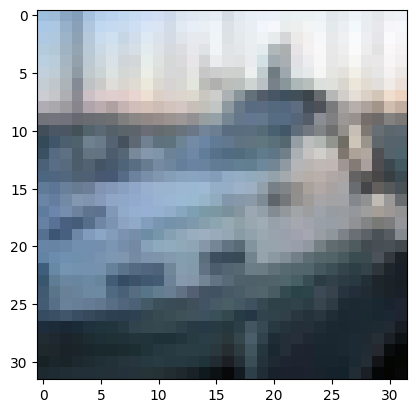

In [10]:
train_dataset, test_dataset = get_datasets('cifar10')

from PIL import Image
import matplotlib.pyplot as plt

clean_img = test_dataset.data[2]
print(clean_img.shape)
plt.imshow(clean_img)

#poison_img=add_pattern_bd(clean_img, dataset='fmnist', pattern_type='square', agent_idx=-1)
#plt.imshow(poison_img)
           
#poison_img=add_pattern_bd(clean_img, dataset='fmnist', pattern_type='square', agent_idx=-1)
#plt.imshow(poison_img)



#train_dataset, test_dataset = get_datasets('cifar10')

#clean_img = test_dataset.data[10]
#print(clean_img.shape)
#plt.imshow(clean_img)




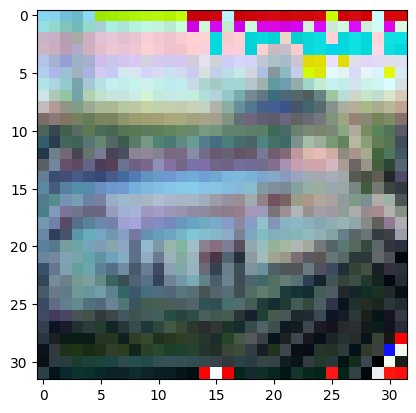

In [11]:
# Generate poisoned image
poison_img = attack_gan(clean_img, 0)

# Select first image from the batch
single_image = poison_img[0]

#plt.imshow(single_image)

 # Convert to numpy, reorder dimensions
image_data = single_image.detach().cpu().numpy().transpose((1, 2, 0))

 # Plot the image
plt.imshow(image_data.astype(np.uint8))








In [ ]:
#poison_img=add_pattern_bd(clean_img, dataset='mnist', pattern_type='square', agent_idx=0)
#poison_img = attack_gan(test_dataset[2], 1)
#plt.imshow(poison_img)

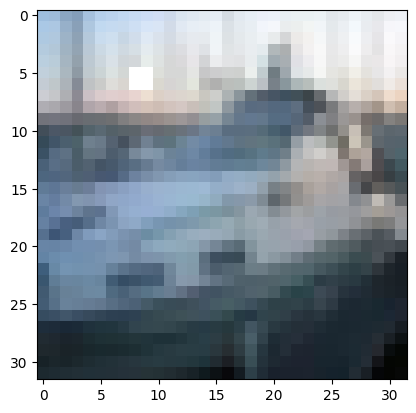

In [ ]:
poison_img=add_pattern_bd(clean_img, dataset='mnist', pattern_type='square', agent_idx=1)
plt.imshow(poison_img)

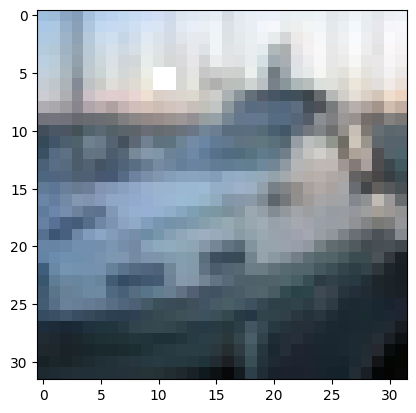

In [ ]:
poison_img=add_pattern_bd(clean_img, dataset='mnist', pattern_type='square', agent_idx=2)
plt.imshow(poison_img)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


#DNN Fedavg paper used
class DNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 30, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 50, 3, padding=1)
        self.fc1 = nn.Linear(50*7*7, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 50*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MNISTClassifier(nn.Module):
    """
    Convolutional neural network used in the tutorial for CleverHans.
    This neural network is also used in experiments by Staib et al. (2017) and
    Sinha et al. (2018).
    """

    def __init__(self, nb_filters=64, activation='relu'):
        """
        The parameters in convolutional layers and a fully connected layer are
        initialized using the Glorot/Xavier initialization, which is the
        default initialization method in Keras.
        """

        super().__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(1, nb_filters, kernel_size=(
            8, 8), stride=(2, 2), padding=(3, 3))
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(nb_filters, nb_filters * 2,
                               kernel_size=(6, 6), stride=(2, 2))
        nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(
            nb_filters * 2, nb_filters * 2, kernel_size=(5, 5), stride=(1, 1))
        nn.init.xavier_uniform_(self.conv3.weight)
        self.fc1 = nn.Linear(nb_filters * 2, 10)
        nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        outputs = self.conv1(x)
        outputs = self.applyActivation(outputs)
        outputs = self.conv2(outputs)
        outputs = self.applyActivation(outputs)
        outputs = self.conv3(outputs)
        outputs = self.applyActivation(outputs)
        outputs = outputs.view((-1, self.num_flat_features(outputs)))
        outputs = self.fc1(outputs)
        # Note that because we use CrosEntropyLoss, which combines
        # nn.LogSoftmax and nn.NLLLoss, we do not need a softmax layer as the
        # last layer.
        return outputs

    def applyActivation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'elu':
            return F.elu(x)
        else:
            raise ValueError("The activation function is not valid.")

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
def relu(x): return max(0.0, x)

def cos_sim(a, b):
    """Takes 2 vectors a, b and returns the cosine similarity.""" 

    dot_product = np.dot(a, b) # x.y
    norm_a = np.linalg.norm(a) #|x|
    norm_b = np.linalg.norm(b) #|y|
    return dot_product / (norm_a * norm_b)

def weights_to_vector(weights):
    """Convert NumPy weights to 1-D Numpy array."""
    Lis=[np.ndarray.flatten(ndarray) for ndarray in weights]
    return np.concatenate(Lis, axis=0)

def vector_to_weights(vector,weights):
    """Convert 1-D Numpy array tp NumPy weights."""
    indies = np.cumsum([0]+[layer.size for layer in weights]) #indies for each layer of a weight
    Lis=[vector[indies[i]:indies[i+1]].reshape(weights[i].shape) for i in range(len(weights))]
    return Lis

def common(a,b): 
    c = [value for value in a if value in b] 
    return c

def exclude(a,b):
    c = [value for value in a if value not in b]
    return c

In [14]:
def average(new_weights):
        fractions=[1/int(num_clients*subsample_rate) for _ in range(int(num_clients*subsample_rate))]
        fraction_total=np.sum(fractions)
        
        # Create a list of weights, each multiplied by the related fraction
        weighted_weights = [
            [layer * fraction for layer in weights] for weights, fraction in zip(new_weights, fractions)
        ]

        # Compute average weights of each layer
        aggregate_weights = [
            reduce(np.add, layer_updates) / fraction_total
            for layer_updates in zip(*weighted_weights)
        ]

        return aggregate_weights

def Krum(old_weight, new_weights, num_attacker):
    """Compute Krum average."""
    
    num_attacker=num_attacker
    grads=[]
    for new_weight in new_weights:
        grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(grad)

    scrs=[]
    for i in grads:
        scr=[]
        for j in grads:
            dif=weights_to_vector(i)-weights_to_vector(j)
            sco=np.linalg.norm(dif)
            scr.append(sco)
        top_k = sorted(scr)[1:len(grads)-2-num_attacker]
        scrs.append(sum(top_k))
    chosen_grads= grads[scrs.index(min(scrs))]
    krum_weights = [w1-w2 for w1,w2 in zip(old_weight, chosen_grads)]
    return krum_weights


def Median(old_weight, new_weights):
    """Compute Median average."""

    grads=[]
    for new_weight in new_weights:
        grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(grad)
    
    med_grad=[]
    for layer in range(len(grads[0])):
        lis=[]
        for weight in grads:
            lis.append(weight[layer])
        arr=np.array(lis)
        med_grad.append(np.median(arr,axis=0))
    Median_weights = [w1-w2 for w1,w2 in zip(old_weight, med_grad)]
    return Median_weights

def GeoMedian(old_weight, new_weights, R):
    """Compute GeoMedian"""
    #R=10
    epsilon=1e-6
    geo_median=np.zeros(len(weights_to_vector(old_weight)))
    vec_weight_lis=[]
    for new_weight in new_weights:
        vec_weight_lis.append(weights_to_vector(new_weight))
    for _ in range(R):
        beta_lis=[]
        for vec_weight in vec_weight_lis:
            beta=1.0/max(np.linalg.norm(vec_weight-geo_median),epsilon)
            beta_lis.append(beta)
        geo_median=np.sum([beta*vec_weight/sum(beta_lis) for beta,vec_weight in zip(beta_lis,vec_weight_lis)], axis=0)
    
    return vector_to_weights(geo_median, old_weight)

def Clipped_Median(old_weights, new_weights, max_norm):
    """Compute Median average."""

    grads=[]
    #for new_weight in new_weights:
        #grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        #grads.append(grad)

    #max_norm=2 #0.5, 1, 2, 5
    for new_weight in new_weights:
        norm_diff=np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights))
        clipped_grad = [(layer_old_weight-layer_new_weight)*min(1,max_norm/norm_diff) for layer_old_weight,layer_new_weight in zip(old_weights, new_weight)]
        grads.append(clipped_grad)
    
    med_grad=[]
    for layer in range(len(grads[0])):
        lis=[]
        for weight in grads:
            lis.append(weight[layer])
        arr=np.array(lis)
        med_grad.append(np.median(arr,axis=0))
    Median_weights = [w1-w2 for w1,w2 in zip(old_weights, med_grad)]
    return Median_weights


def Clipping(old_weight, new_weights, max_norm):
    #max_norm=2 #0.5, 1, 2, 5
    grads=[]
    for new_weight in new_weights:
        norm_diff=np.linalg.norm(weights_to_vector(new_weight)-weights_to_vector(old_weights))
        clipped_grad = [(layer_old_weight-layer_new_weight)*min(1,max_norm/norm_diff) for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(clipped_grad)
    

    fractions=[1/int(num_clients*subsample_rate) for _ in range(int(num_clients*subsample_rate))]
    fraction_total=np.sum(fractions)
        
    # Create a list of weights, each multiplied by the related fraction
    weighted_grads = [
        [layer * fraction for layer in grad] for grad, fraction in zip(grads, fractions)
    ]

    # Compute average weights of each layer
    aggregate_grad = [
        reduce(np.add, layer_updates) / fraction_total
        for layer_updates in zip(*weighted_grads)
    ]

    Centered_weights=[w1-w2 for w1,w2 in zip(old_weight, aggregate_grad)]


    return Centered_weights

def random_noise(weight, gau_rate):
  #gau_rate = 10000
  #m = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1/gau_rate]))
  noisy_weight = copy.deepcopy(weight)
  noisy_weight_vec = weights_to_vector(noisy_weight)
  noisy_weight_vec = noisy_weight_vec + np.random.laplace(0,1/gau_rate,noisy_weight_vec.shape)
  noisy_weight = vector_to_weights(noisy_weight_vec, weight)
  return noisy_weight



def FLtrust(old_weight, new_weights, valid_loader):

    grads=[]
    for new_weight in new_weights:
        grad = [layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]
        grads.append(grad)

    set_parameters(net, old_weight)
    train(net, valid_loader, epochs=1, lr=lr)
    new_weight=get_parameters(net)
    server_grad=[layer_old_weight-layer_new_weight for layer_old_weight,layer_new_weight in zip(old_weight, new_weight)]

    vec_grads=[weights_to_vector(grad) for grad in grads]
    vec_server_grad=weights_to_vector(server_grad)

    TS = [relu(cos_sim(vec_grad ,vec_server_grad)) for vec_grad in vec_grads]
    #print(TS)

    normlized_vec_grads = [np.linalg.norm(vec_server_grad)/np.linalg.norm(vec_grad)*vec_grad for vec_grad in vec_grads]
    normlized_grads = [vector_to_weights(vec_grad, server_grad) for vec_grad in normlized_vec_grads]

    # Caculate ant output every client's weight
    client_weights=[np.linalg.norm(vec_server_grad)/np.linalg.norm(vec_grad)*TC for vec_grad, TC in zip(vec_grads, TS)]

    TS_total=np.sum(TS)
    #print(TS_total)
    #if TS_total<0.5: TS_total=0

    # Create a list of weights, each multiplied by the related fraction
    weighted_grads = [
        [layer * TC for layer in grad] for grad, TC in zip(normlized_grads, TS)
    ]

    # Compute average weights of each layer
    FLtrust_grad = [
        reduce(np.add, layer_updates) / max(TS_total, 1e-8)
        for layer_updates in zip(*weighted_grads)
    ]

    FLtrust_weights = [w1-w2 for w1,w2 in zip(old_weight, FLtrust_grad)]

    return FLtrust_weights

In [15]:
setup = dict(device=DEVICE, dtype=torch.float)

batch_size = 128
num_clients= 100
subsample_rate= 0.1
num_attacker= 10
num_class = 10
fl_epoch=500
lr=0.05
num_class=10
max_norm=2

In [ ]:
train_dataset, val_dataset = get_datasets('cifar10')
base_class=1
data='mnist'
target_class=0
poison_frac=0.5  #0.5
pattern_type='square'

# poison the validation dataset and trainning dataset
idxs = (val_dataset.targets == base_class).nonzero().flatten().tolist()
poisoned_val_set = DatasetSplit(copy.deepcopy(val_dataset), idxs)
#poison_dataset(poisoned_val_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=True)
poison_dataset(poisoned_val_set.dataset, target_class, poison_frac, poison_all=False)
poisoned_val_loader = DataLoader(poisoned_val_set, batch_size=batch_size, shuffle=False)


idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
#poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=False)
poison_dataset(poisoned_train_set.dataset, target_class, poison_frac, poison_all=False)
poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
globle_poisoned_train_iter = mit.seekable(poisoned_train_loader)

poisoned_train_iter_lis=[]
for i in range(3):
    idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
    poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
    #poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, poison_frac, pattern_type,  idxs, poison_all=False, agent_idx=i)
    poison_dataset(poisoned_train_set.dataset, target_class, poison_frac, poison_all=False)
    poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
    poisoned_train_iter = mit.seekable(poisoned_train_loader)
    poisoned_train_iter_lis.append(poisoned_train_iter)

#sub_poisoned_train_iter_lis=[]
#for j in range(10):
    #idxs = (train_dataset.targets == base_class).nonzero().flatten().tolist()
    #poisoned_train_set = DatasetSplit(copy.deepcopy(train_dataset), idxs)
    #poison_dataset(poisoned_train_set.dataset, data, base_class, target_class, (j+1)*0.1, pattern_type,  idxs, poison_all=False)
    #poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=batch_size, shuffle=True)
    #poisoned_train_iter = mit.seekable(poisoned_train_loader)
    #sub_poisoned_train_iter_lis.append(poisoned_train_iter)

#print('size of sub_poisoned_lis:',len(sub_poisoned_train_iter_lis))

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter = mit.seekable(trainloader)


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
[3, 10, 21, 27, 44, 52, 74, 90, 97, 98, 111, 116, 125, 153, 154, 169, 179, 180, 189, 192, 206, 215, 235, 237, 244, 255, 257, 258, 264, 269, 276, 281, 284, 287, 297, 298, 313, 315, 338, 352, 359, 376, 378, 382, 398, 406, 416, 422, 423, 428, 447, 473, 477, 489, 491, 496, 499, 522, 524, 526, 527, 531, 539, 560, 581, 584, 602, 638, 642, 667, 675, 678, 689, 742, 763, 767, 774, 778, 785, 791, 814, 822, 841, 847, 854, 857, 864, 868, 883, 885, 886, 888, 912, 914, 919, 928, 929, 944, 946, 956, 975, 982, 989, 1001, 1010, 1018, 1022, 1023, 1026, 1027, 1036, 1052, 1067, 1072, 1076, 1077, 1078, 1090, 1093, 1103, 1109, 1137, 1152, 1161, 1165, 1183, 1188, 1189, 1197, 1203, 1210, 1237, 1241, 1266, 1295, 1310, 1319, 1322, 1323, 1343, 1365, 1397, 1409, 1434, 1440, 1446, 1461, 1463, 1485, 1514, 1555, 1568, 1573, 1574, 1579, 1596, 1617, 1646, 1651, 1652, 1664, 1686, 1694, 1705, 1712, 1714, 1718, 1719, 1725, 1726, 1728, 1735, 1739,

<ipython-input-8-5ea16283d470>:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bd_img = torch.tensor(bd_img).squeeze()
<ipython-input-8-5ea16283d470>:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset.data[idx] = torch.tensor(bd_img).permute(1, 2, 0)


[29, 30, 35, 49, 77, 93, 115, 116, 129, 165, 179, 185, 189, 199, 213, 220, 223, 233, 264, 276, 279, 284, 293, 308, 317, 332, 341, 344, 348, 349, 352, 371, 373, 376, 392, 401, 404, 405, 407, 415, 417, 436, 439, 448, 453, 455, 457, 467, 468, 481, 497, 504, 527, 555, 557, 564, 598, 600, 604, 605, 608, 614, 626, 628, 637, 650, 658, 663, 687, 694, 695, 698, 700, 708, 713, 731, 733, 735, 748, 752, 757, 765, 782, 783, 799, 812, 822, 843, 866, 871, 872, 902, 905, 906, 911, 927, 938, 940, 965, 974, 983, 989, 1012, 1039, 1044, 1086, 1097, 1119, 1123, 1130, 1142, 1144, 1147, 1166, 1168, 1178, 1185, 1187, 1188, 1195, 1205, 1211, 1214, 1216, 1227, 1234, 1243, 1249, 1260, 1266, 1270, 1278, 1296, 1306, 1319, 1329, 1335, 1338, 1340, 1376, 1381, 1382, 1400, 1424, 1428, 1432, 1434, 1454, 1463, 1466, 1470, 1473, 1477, 1481, 1493, 1507, 1514, 1522, 1524, 1540, 1560, 1589, 1593, 1594, 1598, 1601, 1607, 1626, 1629, 1632, 1664, 1668, 1674, 1684, 1701, 1708, 1709, 1711, 1715, 1740, 1755, 1757, 1759, 1811, 181

In [ ]:
from torch.utils.data import RandomSampler

q=0.1
label = 0

def _build_groups_by_q (dataset, q):
    groups=[]
    for _ in range(10):
      groups.append([])
    for img,lable in dataset:
      if random.random() < (q-0.1)*10 /9:
        groups[lable].append((img,lable))
      else:
        groups[random.randint(0, 9)].append((img,lable))
    return groups

groups=_build_groups_by_q(train_dataset, q)

root_sampler = RandomSampler(groups[label],num_samples=100,replacement=True)
rootloader = DataLoader(groups[label],batch_size=len(root_sampler),sampler=root_sampler)
root_iter=mit.seekable(rootloader)
print(next(root_iter)[1])

counts=[0]*10
root_iter=mit.seekable(rootloader)
for l in next(root_iter)[1]:
    counts[l]+=1
print(counts)

tensor([1, 9, 6, 3, 7, 7, 0, 7, 1, 0, 6, 8, 5, 3, 6, 0, 0, 2, 4, 0, 1, 8, 2, 6,
        5, 9, 4, 3, 0, 7, 7, 6, 4, 4, 1, 1, 8, 2, 3, 4, 8, 3, 8, 9, 4, 7, 4, 4,
        0, 9, 8, 3, 4, 9, 6, 6, 3, 6, 1, 7, 4, 6, 0, 1, 8, 4, 6, 6, 7, 2, 0, 6,
        3, 8, 8, 8, 4, 0, 3, 4, 8, 2, 1, 8, 9, 4, 5, 7, 2, 0, 3, 4, 3, 9, 3, 8,
        3, 0, 3, 0])
[4, 10, 12, 9, 15, 7, 7, 15, 11, 10]


In [ ]:
# Load model and data
#net = MNISTClassifier().to(**setup)
#net=DNN().to(**setup)
net=Net().to(**setup)

random.seed(501) #101, 150, 501
att_ids=random.sample(range(num_clients),num_attacker)
print('attacker ids: ', att_ids)



old_weights = get_parameters(net)


for rnd in range(fl_epoch):
    
    print('---------------------------------------------------')
    print('rnd: ',rnd+1)
    random.seed(rnd)
    cids=random.sample(range(num_clients),int(num_clients*subsample_rate))
    print('chosen clients: ', cids)
    print('selected attackers: ',common(cids, att_ids))
    
    weights_lis=[]
    for cid in exclude(cids,att_ids):  #if there is an attack
    #for cid in cids:  #NA env
        set_parameters(net, old_weights)
        train(net, train_iter, epochs=1, lr=lr)
        new_weight=get_parameters(net)
        weights_lis.append(new_weight)

    #backdoor attack 
    for cid in att_ids:
        set_parameters(net, old_weights)  
        train(net, poisoned_train_iter_lis[random.randint(0, 2)], epochs=1, lr=lr)
        #train(net, globle_poisoned_train_iter, epochs=1, lr=lr) 
        temp_new_weight=get_parameters(net)
        new_weight=temp_new_weight      
        weights_lis.append(new_weight)
     
    
    #aggregate_weights = average(weights_lis)
    #aggregate_weights = Median(old_weights, weights_lis)
    #aggregate_weights = GeoMedian(old_weights, weights_lis, 10)
    #aggregate_weights = Clipped_Median(old_weights, weights_lis, 0.02)
    #aggregate_weights = Krum(old_weights, weights_lis, 2)
    #aggregate_weights=Clipping(old_weights, weights_lis, 0.02)
    aggregate_weights=FLtrust(old_weights, weights_lis, root_iter)
    
    
    #aggregate_weights=random_noise(aggregate_weights, 200)
    old_weights=aggregate_weights
    set_parameters(net, old_weights)
    
    loss, acc = test(net, val_loader)
    poi_loss, poi_acc= test(net, poisoned_val_loader)
    
    print('global_acc: ', acc)
    print('backdoor_acc: ', poi_acc)
    
    f=open('DBA_main_FLtrust100_q0.1_fr0.5_lr0.05_500epoch_mnist_100c_20a.txt','a')
    f.write(str(acc)+'\n')
    f.close()

    f=open('DBA_backdoor_Fltrust100_q0.1_fr0.5_lr0.05_500epoch_mnist_100c_20a.txt','a')
    f.write(str(poi_acc)+'\n')
    f.close()
    


attacker ids:  [81, 36, 80, 45, 30, 41, 43, 67, 46, 21, 91, 57, 92, 58, 1, 47, 59, 2, 96, 27]
---------------------------------------------------
rnd:  1
chosen clients:  [49, 97, 53, 5, 33, 65, 62, 51, 38, 61]
selected attackers:  []


<ipython-input-9-ae9b36e6ab63>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


global_acc:  0.0868
backdoor_acc:  0.23171806167400882
---------------------------------------------------
rnd:  2
chosen clients:  [17, 72, 97, 8, 32, 15, 63, 57, 60, 83]
selected attackers:  [57]
global_acc:  0.0972
backdoor_acc:  0.22819383259911893
---------------------------------------------------
rnd:  3
chosen clients:  [7, 11, 10, 46, 21, 94, 85, 39, 32, 77]
selected attackers:  [46, 21]
global_acc:  0.0974
backdoor_acc:  0.37092511013215856
---------------------------------------------------
rnd:  4
chosen clients:  [30, 75, 69, 16, 47, 77, 60, 80, 74, 8]
selected attackers:  [30, 47, 80]
global_acc:  0.1062
backdoor_acc:  0.46343612334801765
---------------------------------------------------
rnd:  5
chosen clients:  [30, 38, 13, 92, 50, 61, 19, 11, 8, 2]
selected attackers:  [30, 92, 2]
global_acc:  0.1137
backdoor_acc:  0.4713656387665198
---------------------------------------------------
rnd:  6
chosen clients:  [79, 32, 94, 45, 88, 83, 67, 3, 59, 99]
selected attackers:

In [ ]:
final_weights=old_weights
print(net)
print([np.shape(layer) for layer in old_weights])
print([layer.size for layer in old_weights])
print(sum([layer.size for layer in old_weights]))

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
[(10, 1, 5, 5), (10,), (20, 10, 5, 5), (20,), (50, 320), (50,), (10, 50), (10,)]
[250, 10, 5000, 20, 16000, 50, 500, 10]
21840


In [ ]:
class Net_prune(nn.Module):
    def __init__(self, model):
        super(Net_prune, self).__init__()
        self.conv1 = model.conv1
        self.conv2 = model.conv2

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        return x

        # x = F.relu(F.max_pool2d(self.conv2_drop(x), 2))
        # x = x.view(-1, 320)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        # return F.log_softmax(x)

def prune_train(net_prune, train_iter):
    try:
        images, labels = next(train_iter)
    except:
        train_iter.seek(0)
        images, labels = next(train_iter)
    #print(labels)
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    output = net_prune(images)
    prune_output = torch.sum(output, dim=0)
    prune_output = prune_output.div(len(labels))
    return prune_output

def get_prune_rank(prune_output):
    prune_rank = torch.ones(prune_output.size())
    neuron_sum = torch.sum(prune_output, (1, 2))
    sorted_value, indices = torch.sort(neuron_sum)

    rank = 0
    for i in indices:
        for j in range(len(prune_rank.view(prune_rank.size()[0], -1)[i])):
            prune_rank.view(prune_rank.size()[0], -1)[i][j] = rank
        rank += 1
    assert(rank == len(indices))
    
    return prune_rank


def get_prune_mask(prune_rank, prune_num):
    prune_mask = torch.ones(prune_rank.size())
    neuron_sum = torch.sum(prune_rank, (1, 2))
    sorted_value, indices = torch.sort(neuron_sum)

    for i in indices[:prune_num]:
        for j in range(len(prune_mask.view(prune_mask.size()[0], -1)[i])):
            prune_mask.view(prune_mask.size()[0], -1)[i][j] = 0
    
    return prune_mask



class Net_post(nn.Module):
    def __init__(self, model, prune_mask):
        super(Net_post, self).__init__()
        self.conv1 = copy.deepcopy(model.conv1)
        self.conv2 = copy.deepcopy(model.conv2)
        self.conv2_drop = copy.deepcopy(model.conv2_drop)
        self.fc1 = copy.deepcopy(model.fc1)
        self.fc2 = copy.deepcopy(model.fc2)
        #self.prune_mask = copy.deepcopy(prune_mask).cuda()
        self.prune_mask = copy.deepcopy(prune_mask).to(DEVICE)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        
        x = x.mul(self.prune_mask)
        x = F.relu(F.max_pool2d(self.conv2_drop(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)